In [25]:
import pandas as pd
import numpy as  np
import matplotlib.pyplot as plt
import torch
from torch import nn
np.set_printoptions(linewidth=200)

# Synthetic Data Generation

In [26]:
# Synthetic problem
r = np.random.random((12,3))
s = np.random.random((40,3))

q = np.sqrt(np.sum((np.expand_dims(r,1) - np.expand_dims(s,0))**2,axis=2))
offsets_gt = np.random.rand(1,q.shape[1])
q = q + offsets_gt + 0.05*np.random.randn(*q.shape)
outlier_idx = np.random.rand(*q.shape) < 0.1
q[outlier_idx] = np.random.rand(*q.shape)[outlier_idx]*3

tdoa_df = pd.DataFrame(q)
tdoa = tdoa_df.to_numpy()
tdoa_df

,0,1,2,3,4,5,6,7,8,9,...,30,31,32,33,34,35,36,37,38,39
0,0.799167,1.605204,1.995852,1.166502,0.887902,0.439629,1.053714,1.045603,0.633024,0.781121,...,0.436555,0.938103,1.231281,0.977423,0.762809,1.657038,0.794413,1.339076,0.571211,1.762915
1,0.874654,1.519406,2.662668,1.388321,2.054822,1.153831,0.613322,0.847776,0.545768,1.445538,...,0.685636,1.085547,0.824725,1.665812,1.456734,1.027148,1.105278,1.551257,0.813239,2.092641
2,0.858839,1.611884,1.137961,1.333731,1.068095,0.677794,1.018605,0.626380,0.604631,1.114316,...,0.322676,0.859049,0.998932,1.355352,0.732222,1.231596,0.665590,1.084211,0.771778,1.564389
3,1.069992,1.668252,1.413955,1.586725,1.348607,1.196058,0.090398,2.157366,2.356820,1.593439,...,0.827649,1.029577,0.907566,1.791083,1.370967,1.035722,1.180668,1.537546,0.915133,1.623220
4,0.985379,1.642372,1.544812,1.402642,1.160583,0.783853,1.016836,0.552110,0.581350,1.205812,...,0.488827,0.760080,0.948980,1.574881,1.050606,1.294741,0.857752,1.243329,0.979571,1.452971
5,0.543035,1.027566,1.547426,0.964821,1.304017,0.845071,0.736679,0.915263,0.373700,1.012005,...,0.724051,1.197753,1.328963,1.182362,1.227438,1.711086,1.120406,2.184267,0.771658,0.435770
6,1.021482,1.591179,1.600068,1.301523,0.590889,0.684798,1.030120,0.177209,0.641048,2.800425,...,0.668547,1.814397,1.210936,1.579076,1.163361,1.399544,0.865772,1.179742,1.107659,1.303708
7,0.973127,1.583572,1.724784,1.636147,1.283576,1.299140,0.812604,0.888346,0.741038,1.649702,...,0.850389,0.989390,0.916578,1.816426,1.493339,1.087889,1.257658,1.684142,1.151303,1.957084
8,0.355253,0.913831,1.498294,1.041697,0.814316,1.036855,0.622521,1.009190,0.374934,1.235581,...,0.775802,0.390989,1.161164,1.415946,1.212896,1.529771,1.164924,1.562210,0.555465,1.896242
9,1.854961,1.596457,1.544308,1.594522,2.843717,1.264706,0.919485,0.988844,0.815698,1.665082,...,0.910386,0.051707,0.970749,1.731640,1.516886,1.024586,1.223308,1.723625,0.947748,2.083739


# Helper Functions ans Classes

In [27]:
class UvaboSolution():

    def __init__(self, n_receivers, n_senders, dim=3):
        u = np.empty((3, n_receivers))
        u[:] = np.nan
        self.u = u

        v = np.empty((3, n_senders))
        v[:] = np.nan
        self.v = v

        a = np.empty((n_receivers,1))
        a[:] = np.nan
        self.a = a

        b = np.empty((1, n_senders))
        b[:] = np.nan
        self.b = b

        o = np.empty((1,n_senders))
        o[:] = np.nan
        self.o = o

from enum import Enum
from abc import ABC, abstractmethod

def init_uvab(d):
    dsquare = d**2
    doubleCompaction = dsquare - dsquare[0:1,:] - dsquare[:,0:1] + dsquare[0,0]
    uu,ss,vv = np.linalg.svd(doubleCompaction/-2)
    u =uu[:,:3].T
    v = np.diag(ss[:3])@vv[:3,:]
    a = dsquare[:,0:1] - dsquare[0,0]/2
    b = dsquare[0:1,:] - dsquare[0,0]/2
    return u,v,a,b

class TxoaType(Enum):
    TOA = 1
    TDOA = 2
    COTDOA = 3

class TxoaProblem():
    def __init__(self, data, problem_type=TxoaType.TDOA, dim=3):
        self.data = data
        self.sol = UvaboSolution(*data.shape, dim=dim)
        self.problem_type = problem_type
        self.dim = dim

    def solve_for_offset(self, solver, tol=0.01):   
        #sample_subset = lambda : self.data[np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()],np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]]

        outer_ransac_iters = 100
        most_inliers = -1
        best_sol = None
        for _ in range(outer_ransac_iters):
            mics_choice = np.random.permutation(self.data.shape[0])[:solver.get_needed_receivers()]
            sound_choice = np.random.permutation(self.data.shape[1])[:solver.get_needed_senders()]
            data = self.data[mics_choice][:,sound_choice]

            offsets = solver.solve(data)
            d = data - offsets

            u,v,a,b = init_uvab(d)

            cur_solution = UvaboSolution(*self.data.shape,dim=self.dim)

            cur_solution.u[:,mics_choice] = u
            cur_solution.v[:,sound_choice] = v
            cur_solution.a[mics_choice] = a
            cur_solution.b[:,sound_choice] = b
            cur_solution.o[:,sound_choice] = offsets
            cur_problem = TxoaProblem(self.data, problem_type=self.problem_type, dim=self.dim)
            cur_problem.sol = cur_solution

            cur_problem.ransac_expand_to_all_cols()

            res = -2*cur_solution.u.T@cur_solution.v + cur_solution.a + cur_solution.b - (self.data - cur_solution.o)**2

            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = cur_solution
        self.sol = best_sol

    def ransac_expand_col(self, new_sound_idx, ransac_iter=10,tol=0.01):
        needed_eqs = self.dim + 2
        most_inliers = -1
        best_sol = None
        known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]

        for _ in range(ransac_iter):
            mic_local_choice = np.random.permutation(known_mics.shape[0])[:needed_eqs]
            M = np.concatenate([2*self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1],
                                -np.ones((needed_eqs,1)),
                                -2*self.sol.u[:,known_mics[mic_local_choice]].T,
                                np.ones((needed_eqs,1))
                                ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
            B = self.data[known_mics[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - self.sol.a[known_mics[mic_local_choice]]
            if np.any(np.isnan(M)) or np.any(np.isnan(B)):
                print("O no! found none")
                continue
            x_part,_,_,_ = np.linalg.lstsq(M,B,rcond=None)
            x_hom = np.array([0,1,*([0]*self.dim),1])
            x_hom = np.expand_dims(x_hom,1)
            res = x_part[0]**2 - x_part[1]
            x = x_hom*res + x_part 

            o_new = x[0]
            v_new = x[2:5]
            b_new = x[5]

            lh = np.expand_dims((self.data[known_mics,new_sound_idx] - o_new)**2,axis=1)
            rh = -2*self.sol.u[:,known_mics].T@v_new+self.sol.a[known_mics]+b_new

            res = lh - rh
            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = (o_new[0], v_new[:,0], b_new[0])
        self.sol.o[0,new_sound_idx] = best_sol[0]
        self.sol.v[:,new_sound_idx] = best_sol[1]
        self.sol.b[0,new_sound_idx] = best_sol[2]

    def ransac_expand_row(self, new_mic_idx, ransac_iter=10,tol=0.01):
        
        known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
        needed_eqs = self.dim + 1
        most_inliers = -1
        best_sol = None
        for _ in range(ransac_iter):
            sound_choice = known_sounds[np.random.permutation(known_sounds.shape[0])[:needed_eqs]]
            M = np.concatenate([-2*self.sol.v[:,sound_choice].T,
                                np.ones((needed_eqs,1))
                                ],axis=1) # variable order is [o_j, o_j^2, v_j, b_j]
            B = (self.data[new_mic_idx,sound_choice] - self.sol.o[0,sound_choice])**2 - self.sol.b[0,sound_choice]
            #B = tdoa[mics_choice[mic_local_choice],new_sound_idx:new_sound_idx+1]**2 - a[mic_local_choice] 
            if np.any(np.isnan(M)) or np.any(np.isnan(B)):
                print("O no! found none")
                continue
            x = np.linalg.solve(M,B)

            u_new = np.expand_dims(x[:3],axis=1)
            a_new = x[3]

            lh = np.expand_dims((self.data[new_mic_idx,known_sounds] - self.sol.o[:,known_sounds])**2,axis=1)
            rh = -2*u_new.T@self.sol.v[:,known_sounds]+a_new+self.sol.b[:,known_sounds]

            res = lh - rh
            if np.sum(np.abs(res) < tol) > most_inliers:
                most_inliers = np.sum(np.abs(res) < tol)
                best_sol = (u_new, a_new)
        self.sol.u[:,new_mic_idx] = best_sol[0][:,0]
        self.sol.a[new_mic_idx] = best_sol[1]

    def ransac_expand_to_all_cols(self, ransac_iter=10, tol=0.01):
        known_sounds = np.argwhere(np.logical_not(np.isnan(self.sol.b)))[:,1]
        for new_sound in np.setdiff1d(np.arange(self.data.shape[1]),known_sounds):
            self.ransac_expand_col(new_sound,ransac_iter=ransac_iter, tol=tol)
    
    def ransac_expand_to_all_rows(self, ransac_iter=10, tol=0.01):
        known_mics = np.argwhere(np.logical_not(np.isnan(self.sol.a)))[:,0]
        for new_mic in np.setdiff1d(np.arange(self.data.shape[0]),known_mics):
            self.ransac_expand_row(new_mic,ransac_iter=ransac_iter, tol=tol)
        
    def get_residuals(self):
        return (-2*self.sol.u.T@self.sol.v + self.sol.a + self.sol.b) - (self.data - self.sol.o)**2

    def bundle(self, lr=3e-3, steps=30, tol=0.1):
        dtype = torch.float32
        good_rows = np.logical_not(np.isnan(self.sol.a[:,0]))
        good_cols = np.logical_not(np.isnan(self.sol.b[0]))
        u = nn.Parameter(torch.tensor(self.sol.u[:,good_rows],dtype=dtype))
        v = nn.Parameter(torch.tensor(self.sol.v[:,good_cols],dtype=dtype))
        a = nn.Parameter(torch.tensor(self.sol.a[good_rows],dtype=dtype))
        b = nn.Parameter(torch.tensor(self.sol.b[:,good_cols],dtype=dtype))
        o = nn.Parameter(torch.tensor(self.sol.o[:,good_cols],dtype=dtype))
        data = torch.tensor(self.data[good_rows][:,good_cols],dtype=dtype)
        optimizer = torch.optim.Adam([u,v,a,b,o],lr=lr)

        #compute_estimate = lambda u,v,a,b,o : (-2*u.T@v + a + b)**0.5 + o # Had problem with nan values spreading when using this loss space
        compute_part_estimate = lambda u,v,a,b : (-2*u.T@v + a + b)
        
        huberloss = torch.nn.HuberLoss(delta=tol)
        for _ in range(steps):

            est = compute_part_estimate(u,v,a,b)
            good_idx = (est ** 0.5 + o).isnan().logical_not()

            loss = huberloss(est[good_idx],((data - o)**2)[good_idx]) 
            loss += tol*torch.maximum(torch.tensor(0),-est[est.isnan().logical_not()]).mean()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        self.sol.u[:,good_rows] = u.detach().numpy().astype(dtype=self.sol.u.dtype)
        self.sol.v[:,good_cols] = v.detach().numpy().astype(dtype=self.sol.v.dtype)
        self.sol.a[good_rows] = a.detach().numpy().astype(dtype=self.sol.a.dtype)
        self.sol.b[:,good_cols] = b.detach().numpy().astype(dtype=self.sol.b.dtype)
        self.sol.o[:,good_cols] = o.detach().numpy().astype(dtype=self.sol.o.dtype)

class OffsetSolver(ABC):

    @abstractmethod
    def get_needed_receivers():
        pass

    @abstractmethod
    def get_needed_senders():
        pass

    @abstractmethod
    def solve(data):
        pass
    
class OffsetSolver95(OffsetSolver):

    def get_needed_receivers():
        return 9
    
    def get_needed_senders():
        return 5
    
    def solve(data):
        zsquared = data ** 2
        A = np.concatenate([zsquared[:,1:] - zsquared[:,0:1], -2*data[:,1:], 2*data[:,0:1]],axis=1)
        u = np.linalg.solve(A, np.ones(9))
        sols = np.concatenate([u[-1:]/np.sum(u[:4]),u[4:-1]/u[:4]],axis=0)
        return sols


# Run System

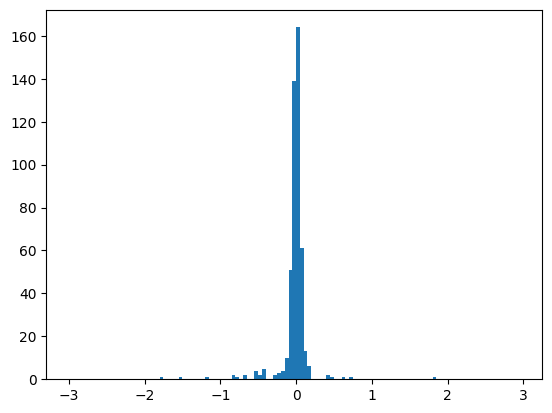

In [36]:
tp = TxoaProblem(tdoa)
tp.solve_for_offset(OffsetSolver95)
tp.bundle(steps=100)
tp.ransac_expand_to_all_rows()
tp.bundle(steps=100)
plt.hist(tp.get_residuals().flatten(),np.arange(-3,3,0.05));